# Importar librerias

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy.stats import wilcoxon
import scipy.stats as stats
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, RocCurveDisplay, auc, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import preprocessor

# Cargar datos

In [2]:

df = pd.read_csv('data/diabetic_data.csv')

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
print('Columna:                      Nulos')
print('-----------------------------------')
df.isnull().sum()

Columna:                      Nulos
-----------------------------------


encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [5]:
columns = list(df.columns)
for col in columns:
    print(col)
    print(df[col].value_counts())
    print('\n\n')

encounter_id
2278392      1
190792044    1
190790070    1
190789722    1
190786806    1
            ..
106665324    1
106657776    1
106644876    1
106644474    1
443867222    1
Name: encounter_id, Length: 101766, dtype: int64



patient_nbr
88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64



race
Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64



gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64



age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64



weight
?            98569


In [6]:
#Eliminar los pacientes que estan repetidos
df=df.drop_duplicates(subset=['patient_nbr'],keep='first')

In [7]:
#Eliminación de IDs
df = df.drop(['payer_code','encounter_id','patient_nbr'], axis = 1)

In [8]:
#Eliminamos los pacientes que han fallecido segun se describe en el doc adjunto
#df = df[~df['discharge_disposition_id'].isin([11, 19, 20, 21])]

In [9]:
#Seleccion de casos
df0 = df[df['readmitted']=='NO']
df1 = df[df['readmitted']=='>30']
df2 = df[df['readmitted']=='<30']

df = pd.concat([df0, df1, df2])
df['readmitted'].value_counts()

NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64

# Tratamiento de las variables

In [10]:
#Transformacion de categorico a numerico
print(df['gender'].unique())
d = {'Female': 0, 'Male': 1,'Unknown/Invalid':-1}
df['gender'] = df['gender'].map(d)
df['gender'].unique()

['Female' 'Male' 'Unknown/Invalid']


array([ 0,  1, -1], dtype=int64)

In [11]:
#Recodificacion de la variable edad de nominal a numerica
d = {'[0-10)'  : 5,
    '[10-20)' : 15,
    '[20-30)' : 25,
    '[30-40)' : 35,
    '[40-50)' : 45,
    '[50-60)' : 55,
    '[60-70)' : 65,
    '[70-80)' : 75,
    '[80-90)' : 85,
    '[90-100)' : 95}
df['age'] = df['age'].map(d)

In [12]:
#  REAGRUPAMIENTO DE LAS CATEGORIAS.
#  0 --> Emergency
#  1 --> Urgent
#  2 --> Elective
#  3 --> Newborn
#  4 --> Trauma Center
#  5 --> Unknown (Not available, NULL, Not Mapped)

d = {1:'emergency',
     2:'urgent',
     3:'elective',
     4:'newborn',
     5: np.nan,
     6: np.nan,
     7: 'traumat',
     8: np.nan}
df['admission_type_id'] = df["admission_type_id"].map(d)


df = pd.get_dummies(df, columns = ['admission_type_id'])
# df = df.drop(df[['admission_type_id_newborn', 'admission_type_id_traumat']], axis=1)

In [13]:

# discharge_disposition_id	description
# 1	Discharged to home
# 2	Discharged/transferred to another short term hospital
# 3	Discharged/transferred to SNF
# 4	Discharged/transferred to ICF
# 5	Discharged/transferred to another type of inpatient care institution
# 6	Discharged/transferred to home with home health service
# 7	Left AMA
# 8	Discharged/transferred to home under care of Home IV provider
# 9	Admitted as an inpatient to this hospital
# 10	Neonate discharged to another hospital for neonatal aftercare
# 11	Expired
# 12	Still patient or expected to return for outpatient services
# 13	Hospice / home
# 14	Hospice / medical facility
# 15	Discharged/transferred within this institution to Medicare approved swing bed
# 16	Discharged/transferred/referred another institution for outpatient services
# 17	Discharged/transferred/referred to this institution for outpatient services
# 18	NULL, Not Mapped, Unknown/Invalid
# 19	Expired at home. Medicaid only, hospice.
# 20	Expired in a medical facility. Medicaid only, hospice.
# 21	Expired, place unknown. Medicaid only, hospice.
# 22	Discharged/transferred to another rehab fac including rehab units of a hospital .
# 23	Discharged/transferred to a long term care hospital.
# 24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
# 25	-->18
# 26	-->18
# 30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
# 27	Discharged/transferred to a federal health care facility.
# 28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
# 29	Discharged/transferred to a Critical Access Hospital (CAH).
d = {1:'home',
     2:'transfer',
     3:'transfer',
     4:'transfer',
     5:'transfer',
     6:'home',
     7:'home',
     8:'home',
     9:'hospital',
     10:'transfer',
     11:'expired',
     12:'hospital',
     13:'expired',
     14:'expired',
     15:'transfer',
     16:'transfer',
     17:'transfer',
     18:np.nan,
     19:'expired',
     20:'expired',
     21:'expired',
     22:'transfer',
     23:'transfer',
     24:'transfer',
     25:np.nan,
     26:np.nan,
     27:'transfer',
     28:'transfer',
     29:'transfer',
     30:'transfer'}

df['discharge_disposition_id'] = df['discharge_disposition_id'].map(d)
df = df.drop(df.loc[df['discharge_disposition_id']=='expired'].index)
df = pd.get_dummies(df, columns = ['discharge_disposition_id','admission_type_id'])


KeyError: "['admission_type_id'] not in index"

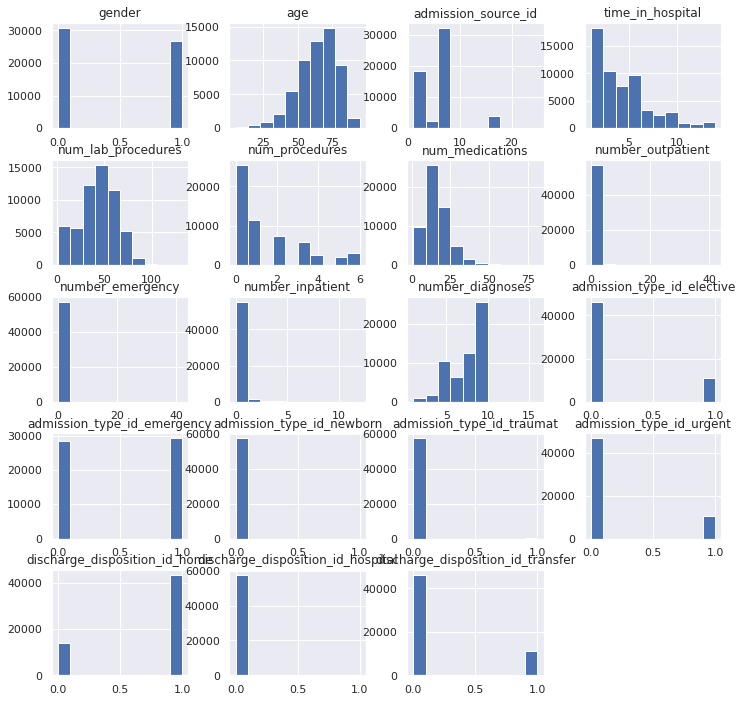

In [ ]:
df.hist(figsize=(12,12))
plt.show()

In [ ]:


#Creacion de una variable de uso de servicios sanitaarios
df['n_service_uses'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df = df.drop(df[['number_outpatient', 'number_emergency', 'number_inpatient']],axis=1)
df['sqrt_n_service_uses'] = np.sqrt(df['n_service_uses'])


In [ ]:
def clasif_diag(diag):
    try:
        num = float(diag)
        if 0<= num <= 139:
            return 'INFECTIOUS AND PARASITIC DISEASES'
        elif 140 <= num <= 239:
            return 'NEOPLASMS'
        elif 240 <= num <= 279:
            return 'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS'
        elif 280 <= num <= 289:
            return 'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS'
        elif 290 <= num <= 319:
            return 'MENTAL DISORDERS'
        elif 320 <= num <= 389:
            return 'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS'
        elif 390 <= num <= 459:
            return 'DISEASES OF THE CIRCULATORY SYSTEM'
        elif 460 <= num <= 519:
            return 'DISEASES OF THE RESPIRATORY SYSTEM'
        elif 520 <= num <= 579:
            return 'DISEASES OF THE DIGESTIVE SYSTEM'
        elif 580 <= num <= 629:
            return 'DISEASES OF THE GENITOURINARY SYSTEM'
        elif 630 <= num <= 679:
            return 'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM'
        elif 680 <= num <= 709:
            return 'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE'
        elif 710 <= num <= 739:
            return 'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE'
        elif 740 <= num <= 759:
            return 'CONGENITAL ANOMALIES'
        elif 760 <= num <= 779:
            return 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD'
        elif 780 <= num <= 799:
            return 'SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS'
        elif 800 <= num <= 999:
            return 'INJURY AND POISONING'

    except ValueError:
        num = str(diag)
        if num.startswith('E'):
            return 'SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES'
        elif num.startswith('V'):
            return 'SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING'




df['diag_1'] = df['diag_1'].apply(clasif_diag)
# df['diag_2'] = df['diag_2'].apply(clasif_diag)
# df['diag_3'] = df['diag_3'].apply(clasif_diag)


d = {'INFECTIOUS AND PARASITIC DISEASES':0,
    'NEOPLASMS':1,
    'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS':2,
    'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS':3,
    'MENTAL DISORDERS':4,
    'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS':5,
    'DISEASES OF THE CIRCULATORY SYSTEM':6,
    'DISEASES OF THE RESPIRATORY SYSTEM':7,
    'DISEASES OF THE DIGESTIVE SYSTEM':8,
    'DISEASES OF THE GENITOURINARY SYSTEM':9,
    'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM':10,
    'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE':11,
    'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE':12,
    'CONGENITAL ANOMALIES':13,
    'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD':14,
    'SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS':15,
    'INJURY AND POISONING' :16,
    'SUPPLEMENTARY CLASSIFICATION OF FACTORS INFLUENCING HEALTH STATUS AND CONTACT WITH HEALTH SERVICES' :17,
    'SUPPLEMENTARY CLASSIFICATION OF EXTERNAL CAUSES OF INJURY AND POISONING':18}

df['diag_1'] = df['diag_1'].map(d)
# df['diag_2'] = df['diag_2'].map(d)
# df['diag_3'] = df['diag_3'].map(d)
df = df.drop(df[['diag_2', 'diag_3']], axis =1)
df = pd.get_dummies(df, columns = ['diag_1'])

In [ ]:
d = {'None':0 , 'Norm': 1, '>200': 2, '>300': 3}
df['max_glu_serum'] = df['max_glu_serum'].map(d)

In [ ]:
d = {'None':0 , 'Norm': 1, '>7': 2, '>8': 3}
df['A1Cresult'] = df['A1Cresult'].map(d)

In [ ]:
d = {'No':0 , 'Down': 1, 'Steady': 2, 'Up': 3}


df['insulin'] = df['insulin'].map(d)
df['metformin'] = df['metformin'].map(d)
df['glimepiride'] = df['glimepiride'].map(d)
df['glipizide'] = df['glipizide'].map(d)
df['glyburide'] = df['glyburide'].map(d)
df['pioglitazone'] = df['pioglitazone'].map(d)
df['rosiglitazone'] = df['rosiglitazone'].map(d)


In [ ]:
d = {'No':0 , 'Ch': 1}
df['change'] = df['change'].map(d)

In [ ]:
d = {'No':0 , 'Yes': 1}
df['diabetesMed'] = df['diabetesMed'].map(d)

In [ ]:
dic = {'NO': 0, '>30':2, '<30':1}
df['readmitted'] = df['readmitted'].map(dic)

In [ ]:
df = df.drop(df[['race','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone','n_service_uses']], axis = 1)

In [ ]:
df['readmitted'].value_counts()

0    29010
2    22222
1     6277
Name: readmitted, dtype: int64

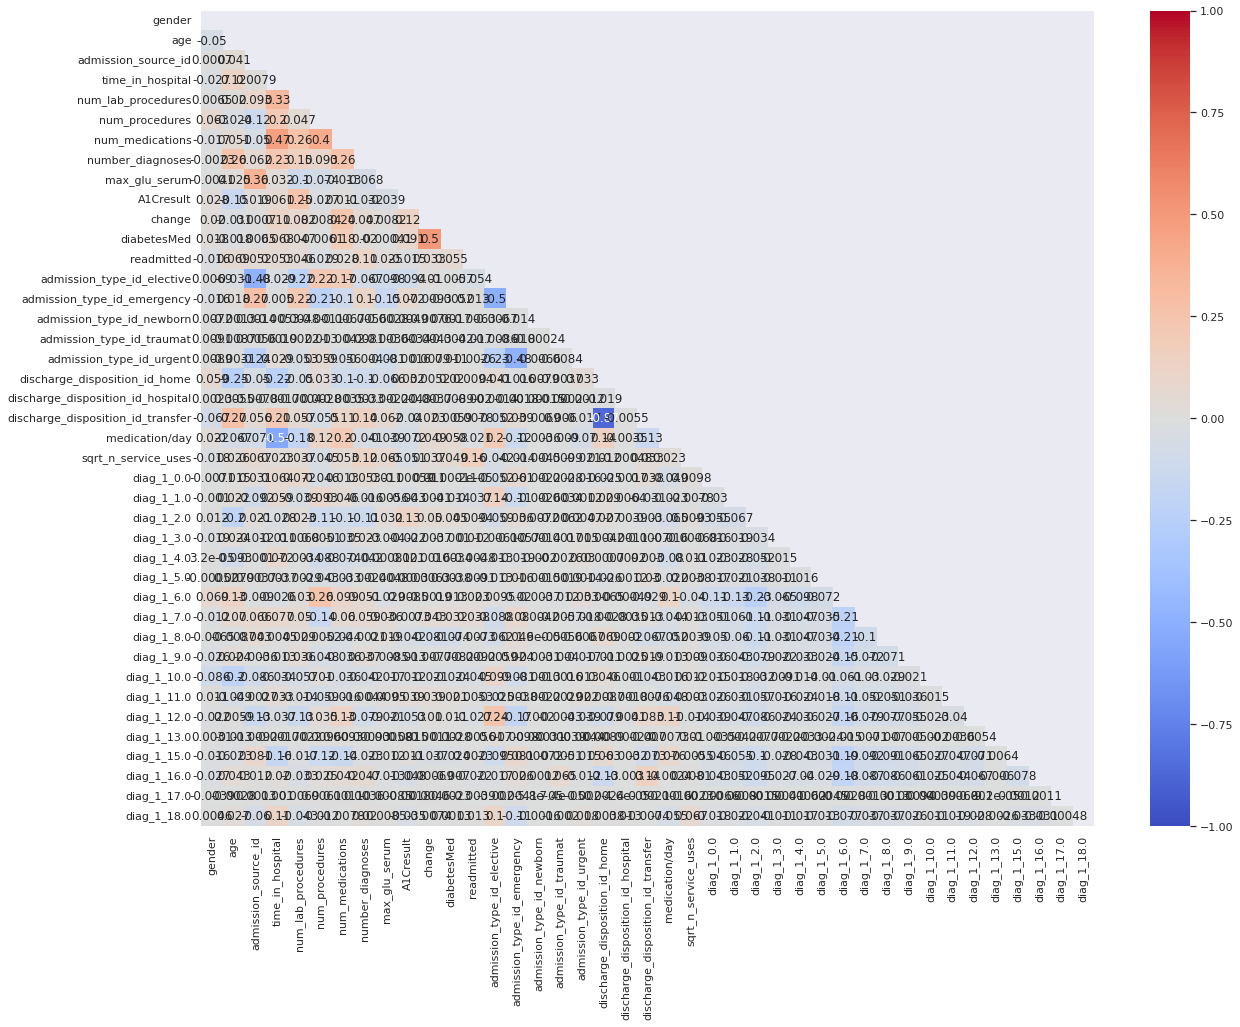

In [ ]:
sns.set(rc={"figure.figsize":(20, 15)})

upp_mat = np.triu(df.corr())

sns.heatmap(df.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)
plt.show()

In [ ]:
for c in list(df.columns):
    print(c)
    print(df[c].value_counts())
    print('\n\n')

gender
0    30718
1    26791
Name: gender, dtype: int64



age
75    14784
65    12838
55    10027
85     9258
45     5530
35     2133
95     1452
25      947
15      417
5       123
Name: age, dtype: int64



admission_source_id
7     30908
1     17692
17     4020
4      1980
6      1386
2       764
5       398
20      138
3       117
9        76
8        16
10        5
25        4
14        3
11        1
22        1
Name: admission_source_id, dtype: int64



time_in_hospital
3     10365
2      9995
1      8321
4      7738
5      5500
6      4179
7      3260
8      2393
9      1634
10     1250
11      947
12      787
13      624
14      516
Name: time_in_hospital, dtype: int64



num_lab_procedures
1      1776
43     1569
44     1370
45     1310
46     1256
       ... 
108       2
111       1
113       1
114       1
132       1
Name: num_lab_procedures, Length: 112, dtype: int64



num_procedures
0    25532
1    11435
2     7264
3     5740
6     3134
4     2472
5     1932
Name: num_pr

In [ ]:
df = df.drop(df[['admission_source_id','max_glu_serum',
                 'A1Cresult','admission_type_id_newborn',
                'admission_type_id_traumat','discharge_disposition_id_hospital',
                'diag_1_0.0', 'diag_1_3.0','diag_1_5.0',
                 'diag_1_4.0', 'diag_1_10.0','diag_1_11.0', 'diag_1_13.0',
                'diag_1_17.0','diag_1_18.0']], axis=1)

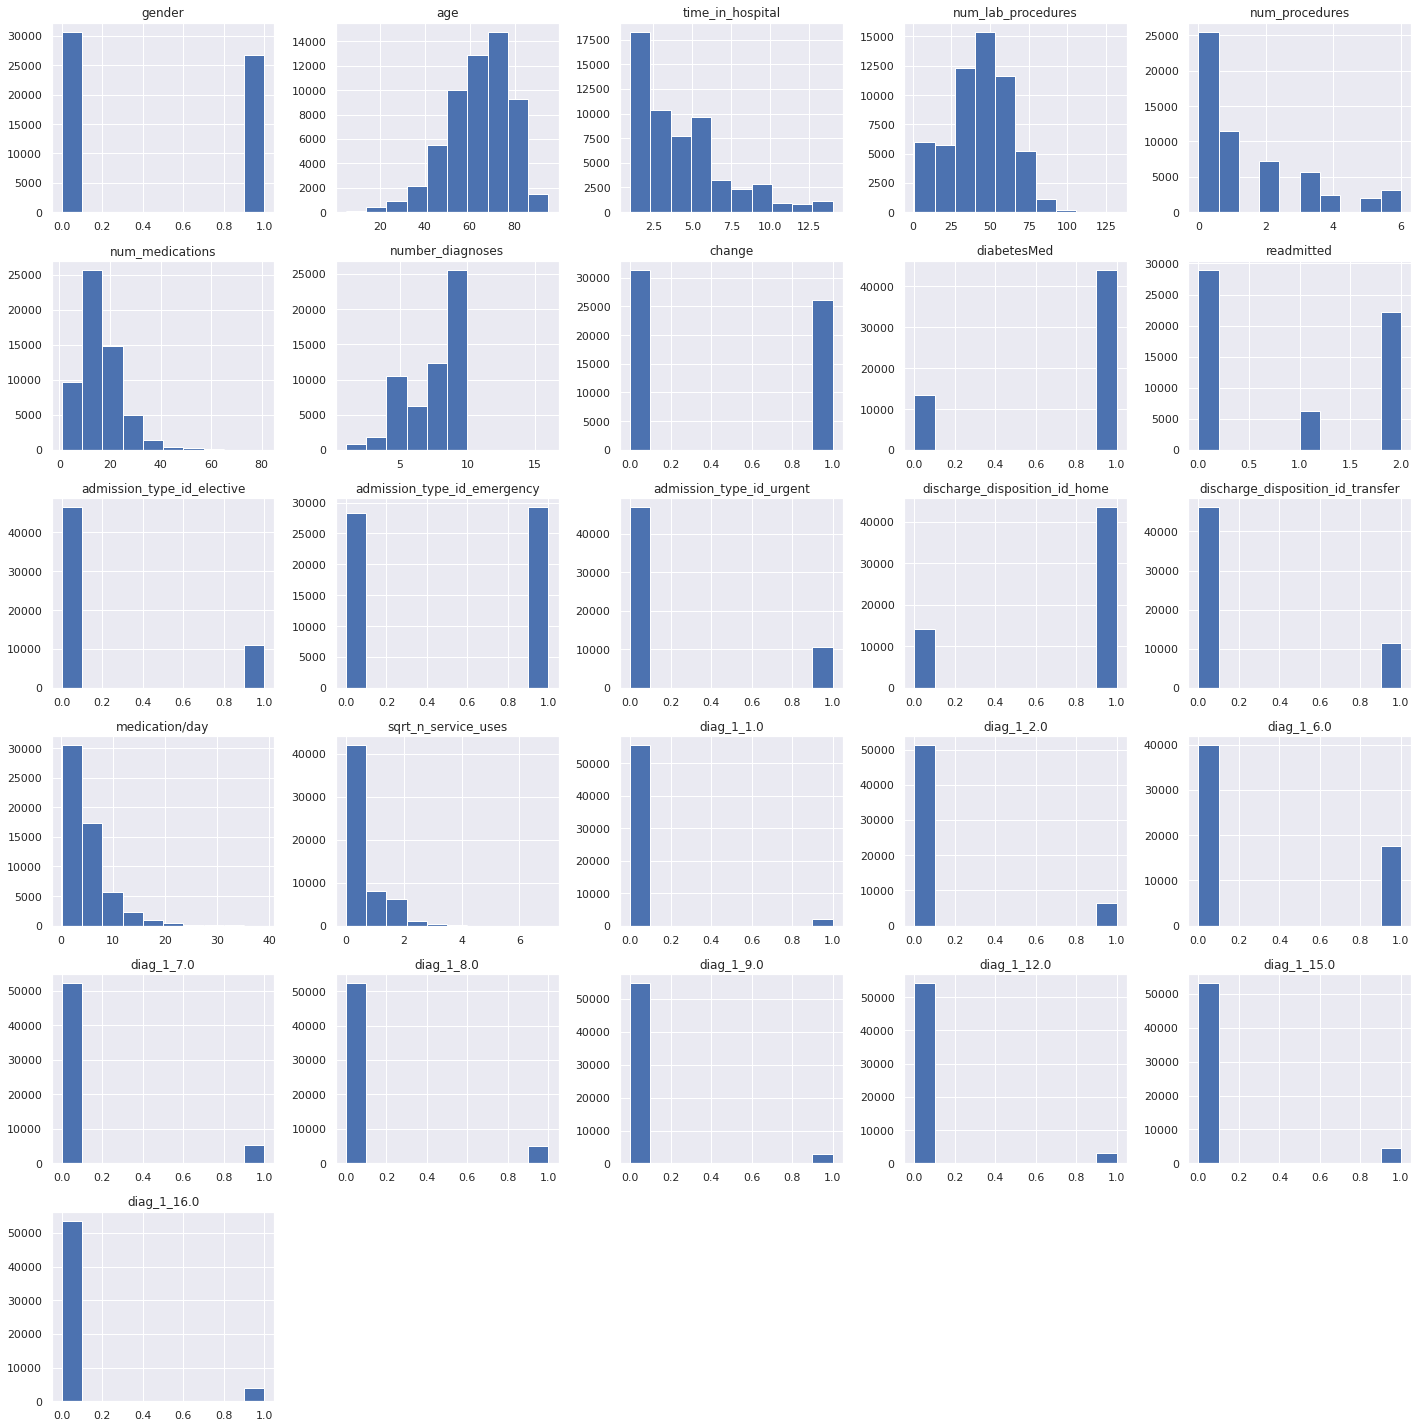

In [ ]:
df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

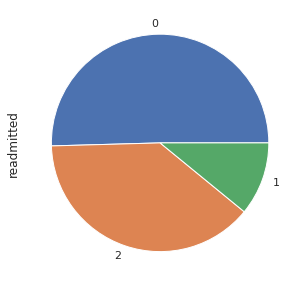

In [ ]:
sns.set(rc={"figure.figsize":(5, 5)})
df.readmitted.value_counts().plot.pie()
plt.show()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
# sns.pairplot(df,
#              hue = 'readmitted',
#              vars = ['age', 'time_in_hospital', 'num_lab_procedures', 'medication/day', 'sqrt_n_service_uses'] )
# plt.show()

In [ ]:
y = df['readmitted']
X = df.copy()
X = X.drop('readmitted', axis=1)

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=5)
# X = pca.fit_transform(X)
# print(pca.explained_variance_ratio_.cumsum())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [ ]:
!pip install featurewiz

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (40256, 26)
    Loaded train data. Shape = (40256, 26)
    Some column names had special characters which were removed...
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
######################################

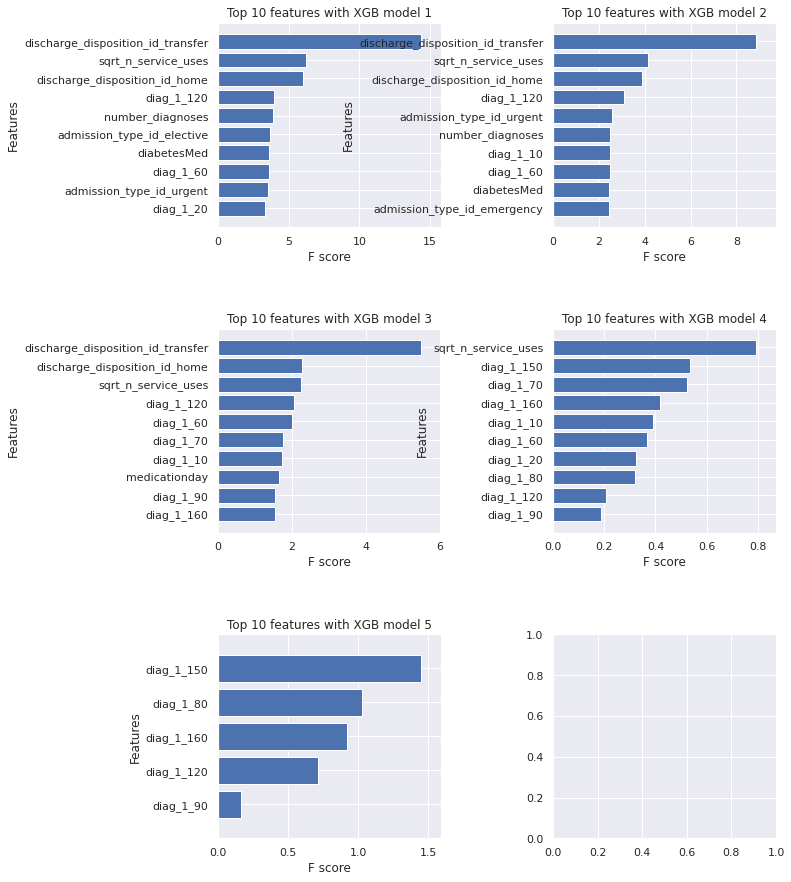

            Total time taken for XGBoost feature selection = 5 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 18 important features:
['discharge_disposition_id_transfer', 'sqrt_n_service_uses', 'discharge_disposition_id_home', 'diag_1_120', 'number_diagnoses', 'admission_type_id_elective', 'diabetesMed', 'diag_1_60', 'admission_type_id_urgent', 'diag_1_20', 'diag_1_10', 'admission_type_id_emergency', 'diag_1_70', 'medicationday', 'diag_1_90', 'diag_1_160', 'diag_1_150', 'diag_1_80']

    Time taken for feature selection = 6 seconds
    Reverted column names to original names given in train dataset
    Time taken to create entire pipeline = 5 second(s)


['discharge_disposition_id_transfer',
 'sqrt_n_service_uses',
 'discharge_disposition_id_home',
 'diag_1_12.0',
 'number_diagnoses',
 'admission_type_id_elective',
 'diabetesMed',
 'diag_1_6.0',
 'admission_type_id_urgent',
 'diag_1_2.0',
 'diag_1_1.0',
 'admission_type_id_emergency',
 'diag_1_7.0',
 'medication/day',
 'diag_1_9.0',
 'diag_1_16.0',
 'diag_1_15.0',
 'diag_1_8.0']

In [ ]:
from featurewiz import FeatureWiz
features = FeatureWiz(corr_limit=0.70,  dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = features.fit_transform(X_train, y_train)
X_test_selected = features.transform(X_test)
features.features  ### provides the list of selected features ###

In [ ]:
categories=['discharge_disposition_id_transfer',
 'sqrt_n_service_uses',
 'discharge_disposition_id_home',
 'diag_1_12.0',
 'admission_type_id_elective',
 'number_diagnoses',
 'diabetesMed',
 'diag_1_6.0',
 'admission_type_id_urgent',
 'diag_1_2.0',
 'diag_1_1.0',
 'diag_1_16.0',
 'diag_1_7.0',
 'medication/day',
 'diag_1_15.0',
 'diag_1_8.0',
 'diag_1_9.0']

X = X[categories]
X_train = X_train[categories]
X_test = X_test[categories]

#modelos

In [ ]:
labels=list(X.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
print(f'Tamaño de X: {len(X)}')
print(f'Tamaño de y: {len(y)}')


Tamaño de X: 57509
Tamaño de y: 57509


In [ ]:
y.value_counts()

0    29010
2    22222
1     6277
Name: readmitted, dtype: int64

#MOdelos normales

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#Ejemplo de smote con cv
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
classifiers_list = [
  ( 'Baseline',              DummyClassifier() ),
  ( 'Nearest Neighbors (1)', KNeighborsClassifier(1) ),
  ( 'Nearest Neighbors (3)', KNeighborsClassifier(3) ),
  ( 'Nearest Neighbors (5)', KNeighborsClassifier(5) ),
  ( 'Nearest Neighbors (7)', KNeighborsClassifier(7) ),

  ( 'Decision Tree',         DecisionTreeClassifier() ),
  ( 'Random Forest',         RandomForestClassifier() ),
  ( 'Neural Net',            MLPClassifier() ),
  ( 'AdaBoost',              AdaBoostClassifier() ),
  ( 'Naive Bayes',           GaussianNB() ),
  ( 'Logistic Regression',   LogisticRegression() ),
]

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}
Baseline
ROC AREA CV: 0.5
 ROC AREA TEST: 0.5


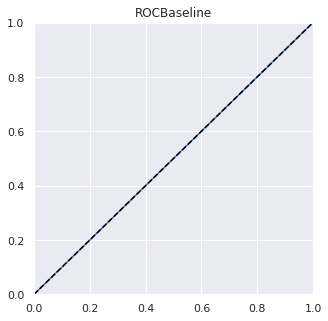

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701]}
Nearest Neighbors (1)
ROC AREA CV: 0.6854901669634541
 ROC AREA TEST: 0.5716758163861287


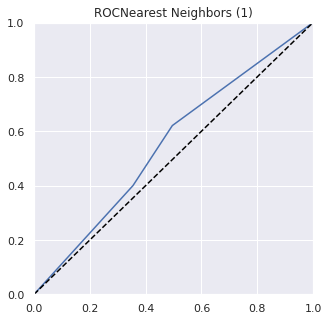

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341]}
Nearest Neighbors (3)
ROC AREA CV: 0.7269703691512414
 ROC AREA TEST: 0.5821027139220885


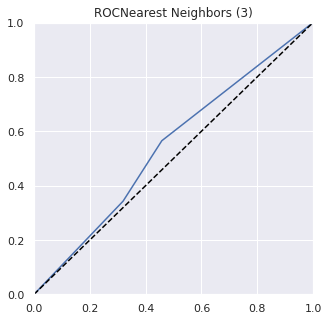

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341], 'Nearest Neighbors (5)': [0.738848965279106, 0.7342781427467303, 0.727476976161839, 0.7399181870699163, 0.725716143807832, 0.7320470492951626, 0.7355816545456629, 0.7334526287845571, 0.7291362144499679, 0.7356989082050891]}
Nearest Neighbors (5)
ROC AREA CV: 0.7332154870345863
 ROC AREA TEST: 0.5776806558746758


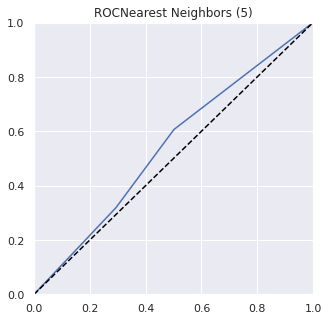

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341], 'Nearest Neighbors (5)': [0.738848965279106, 0.7342781427467303, 0.727476976161839, 0.7399181870699163, 0.725716143807832, 0.7320470492951626, 0.7355816545456629, 0.7334526287845571, 0.7291362144499679, 0.7356989082050891], 'Nearest Neighbors (7)': [0.7317780499419673, 0.7281473296552541, 0.7191013759256233, 0.7357024732056004, 0.7245980027680535, 0.7283133773327147, 0.7290755041946864, 0.7313094264979877, 0.7237564698927317, 0.7332437849899606]}
Nearest Neighbors (7)
ROC AREA C

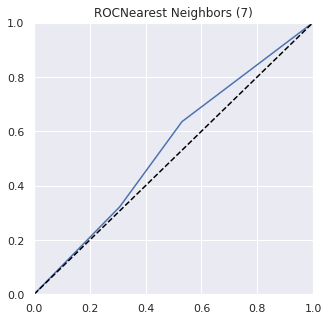

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341], 'Nearest Neighbors (5)': [0.738848965279106, 0.7342781427467303, 0.727476976161839, 0.7399181870699163, 0.725716143807832, 0.7320470492951626, 0.7355816545456629, 0.7334526287845571, 0.7291362144499679, 0.7356989082050891], 'Nearest Neighbors (7)': [0.7317780499419673, 0.7281473296552541, 0.7191013759256233, 0.7357024732056004, 0.7245980027680535, 0.7283133773327147, 0.7290755041946864, 0.7313094264979877, 0.7237564698927317, 0.7332437849899606], 'Decision Tree': [0.713667191843

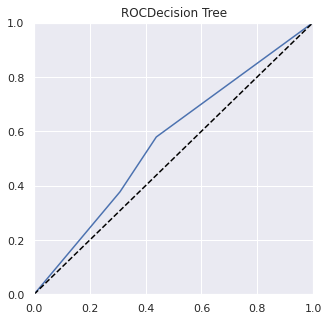

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341], 'Nearest Neighbors (5)': [0.738848965279106, 0.7342781427467303, 0.727476976161839, 0.7399181870699163, 0.725716143807832, 0.7320470492951626, 0.7355816545456629, 0.7334526287845571, 0.7291362144499679, 0.7356989082050891], 'Nearest Neighbors (7)': [0.7317780499419673, 0.7281473296552541, 0.7191013759256233, 0.7357024732056004, 0.7245980027680535, 0.7283133773327147, 0.7290755041946864, 0.7313094264979877, 0.7237564698927317, 0.7332437849899606], 'Decision Tree': [0.713667191843

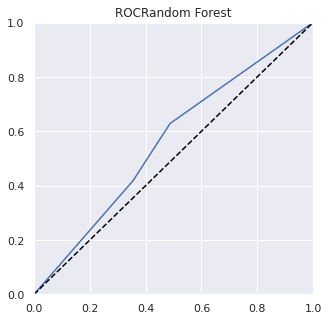

{'Baseline': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'Nearest Neighbors (1)': [0.6862383062530774, 0.684958294027694, 0.6933302021572129, 0.6908671884839354, 0.6823714212446413, 0.6834800685005445, 0.6896362485434722, 0.6795352495025709, 0.6832262230939232, 0.6812584678274701], 'Nearest Neighbors (3)': [0.7298280517076403, 0.7276601653561906, 0.7278782687254145, 0.7347208593943595, 0.720576041006344, 0.7252050486710688, 0.7244354691849226, 0.7260666660358441, 0.7275920803191944, 0.7257410411114341], 'Nearest Neighbors (5)': [0.738848965279106, 0.7342781427467303, 0.727476976161839, 0.7399181870699163, 0.725716143807832, 0.7320470492951626, 0.7355816545456629, 0.7334526287845571, 0.7291362144499679, 0.7356989082050891], 'Nearest Neighbors (7)': [0.7317780499419673, 0.7281473296552541, 0.7191013759256233, 0.7357024732056004, 0.7245980027680535, 0.7283133773327147, 0.7290755041946864, 0.7313094264979877, 0.7237564698927317, 0.7332437849899606], 'Decision Tree': [0.713667191843

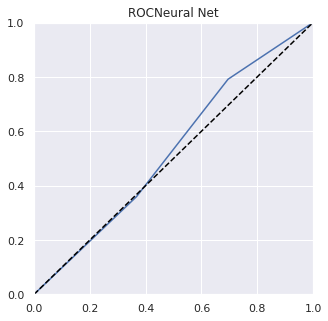

In [ ]:
valores_auc={}
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
for name, model in classifiers_list:
  stratified_kfold = StratifiedKFold(n_splits=10,
                                        shuffle=True,
                                        random_state=11)

  param_grid = {}
  grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='roc_auc_ovr',
                            cv=stratified_kfold,
                            n_jobs=-1)

  grid_search.fit(X_train, y_train)
  valores_auc[name]=[grid_search.cv_results_['split0_test_score'][0],grid_search.cv_results_['split1_test_score'][0],grid_search.cv_results_['split2_test_score'][0],grid_search.cv_results_['split3_test_score'][0],grid_search.cv_results_['split4_test_score'][0],grid_search.cv_results_['split5_test_score'][0],grid_search.cv_results_['split6_test_score'][0],grid_search.cv_results_['split7_test_score'][0],grid_search.cv_results_['split8_test_score'][0],grid_search.cv_results_['split9_test_score'][0]]
  print(valores_auc)
  cv_score = grid_search.best_score_
  test_score = grid_search.score(X_test, y_test)
  print(f'{name}\nROC AREA CV: {cv_score}\n ROC AREA TEST: {test_score}')
  y_pred=grid_search.predict(X_test)
  roc = roc_curve(y_test, y_pred, pos_label=1)
  sns.lineplot(x=roc[0], y=roc[1])
  sns.lineplot(x=[0,1], y=[0,1], linestyle='--', color='black')
  plt.xlim([0,1])
  plt.ylim([0,1])
  plt.title("ROC"+name)
  plt.show()

Baseline
 accuracy CV: 0.333234843510615
 accuracy TEST: 0.504434011476265


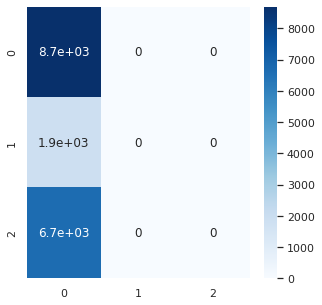

Nearest Neighbors (1)
 accuracy CV: 0.5806536170210932
 accuracy TEST: 0.49637744160435865


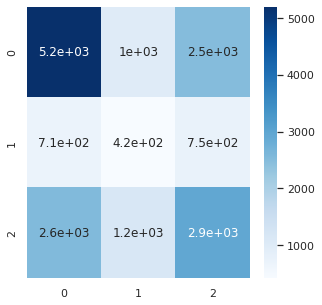

Nearest Neighbors (3)
 accuracy CV: 0.5571641876370406
 accuracy TEST: 0.48165536428447225


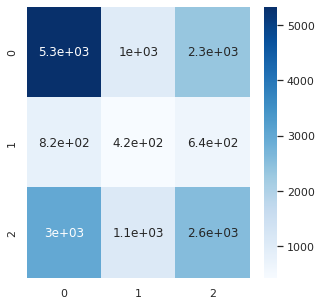

Nearest Neighbors (5)
 accuracy CV: 0.5520918971093595
 accuracy TEST: 0.44595142873703125


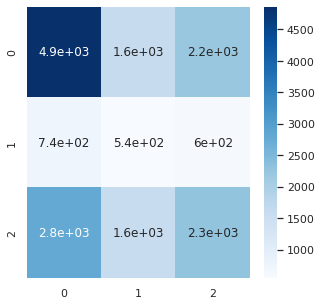

Nearest Neighbors (7)
 accuracy CV: 0.5420625037245522
 accuracy TEST: 0.44328522575783924


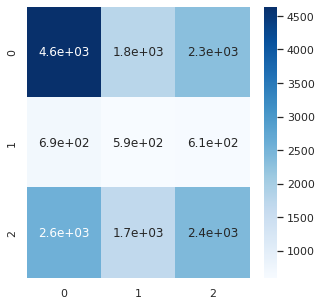

Decision Tree
 accuracy CV: 0.5841991725109134
 accuracy TEST: 0.5027531443806874


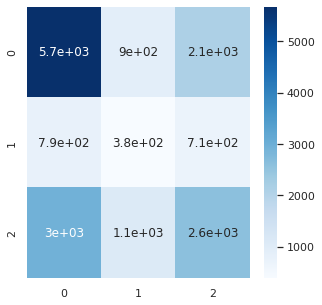

Random Forest
 accuracy CV: 0.6056039599169752
 accuracy TEST: 0.5076798237987596


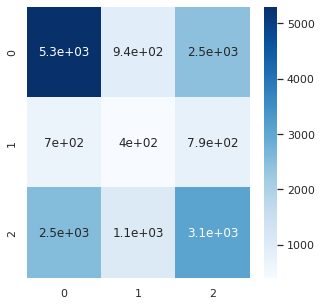

KeyboardInterrupt: ignored

In [ ]:
valores_acc={}
for name, model in classifiers_list:
  stratified_kfold = StratifiedKFold(n_splits=10,
                                        shuffle=True,
                                        random_state=11)

  param_grid = {}
  grid_search = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            scoring='accuracy',
                            cv=stratified_kfold,
                            n_jobs=-1)

  grid_search.fit(X_train, y_train)
  valores_acc[name]=[grid_search.cv_results_['split0_test_score'][0],grid_search.cv_results_['split1_test_score'][0],grid_search.cv_results_['split2_test_score'][0],grid_search.cv_results_['split3_test_score'][0],grid_search.cv_results_['split4_test_score'][0],grid_search.cv_results_['split5_test_score'][0],grid_search.cv_results_['split6_test_score'][0],grid_search.cv_results_['split7_test_score'][0],grid_search.cv_results_['split8_test_score'][0],grid_search.cv_results_['split9_test_score'][0]]
  cv_score = grid_search.best_score_
  test_score = grid_search.score(X_test, y_test)
  print(f'{name}\n accuracy CV: {cv_score}\n accuracy TEST: {test_score}')
  prediction_clf=grid_search.predict(X_test)
  cm = confusion_matrix(y_test, prediction_clf)
  sns.heatmap(cm, annot=True,cmap="Blues")
  plt.show()

## test de wilcoxon

### con accuracy

In [ ]:
plt.plot(range(len(valores_acc['Decision Tree'])),valores_acc['Decision Tree'],'ro-',label='decission_tree')
plt.plot(range(len(valores_acc['Random Forest'])),valores_acc['Random Forest'],'bs-',label='RF')
plt.ylabel('Aciertos')
plt.xlabel('Prueba')
plt.legend()

In [ ]:
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')

wilcox_V, p_value =  wilcoxon(valores_acc['Decision Tree'], valores_acc['Random Forest'], alternative='greater', zero_method='wilcox', correction=False)

print('Resultado completo del test de Wilcoxon')
print(f'Wilcox V: {wilcox_V}, p-value: {p_value:.2f}')

### con ROC area

In [ ]:
plt.plot(range(len(valores_auc['Decision Tree'])),valores_auc['Decision Tree'],'ro-',label='decission_tree')
plt.plot(range(len(valores_auc['Random Forest'])),valores_auc['Random Forest'],'bs-',label='RF')
plt.ylabel('Aciertos')
plt.xlabel('Prueba')
plt.legend()

TypeError: ignored

In [ ]:
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')

wilcox_V, p_value =  wilcoxon(valores_auc['Decision Tree'], valores_auc['Random Forest'], alternative='greater', zero_method='wilcox', correction=False)

print('Resultado completo del test de Wilcoxon')
print(f'Wilcox V: {wilcox_V}, p-value: {p_value:.2f}')

## balanced random forest

In [ ]:

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', BalancedRandomForestClassifier()]]

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)

param_grid = {}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc_ovr',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

##VISUALIZACIÓN DECISSION TREE

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=100)
#Obtenicon del roc area aplicando cross validation
auc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr', verbose=1, n_jobs = 10)
#Obtenicon de la accuracy aplicando cross validation
acc = cross_val_score(clf, X, y, cv=10, scoring='accuracy', verbose=1, n_jobs = 10)
print(auc.mean())
print(acc.mean())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.3s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.5s remaining:    2.0s


0.5813750176446262
0.5227878402999856


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.1s finished


Profundidad del árbol: 28
Número de nodos terminales: 9944


AttributeError: ignored

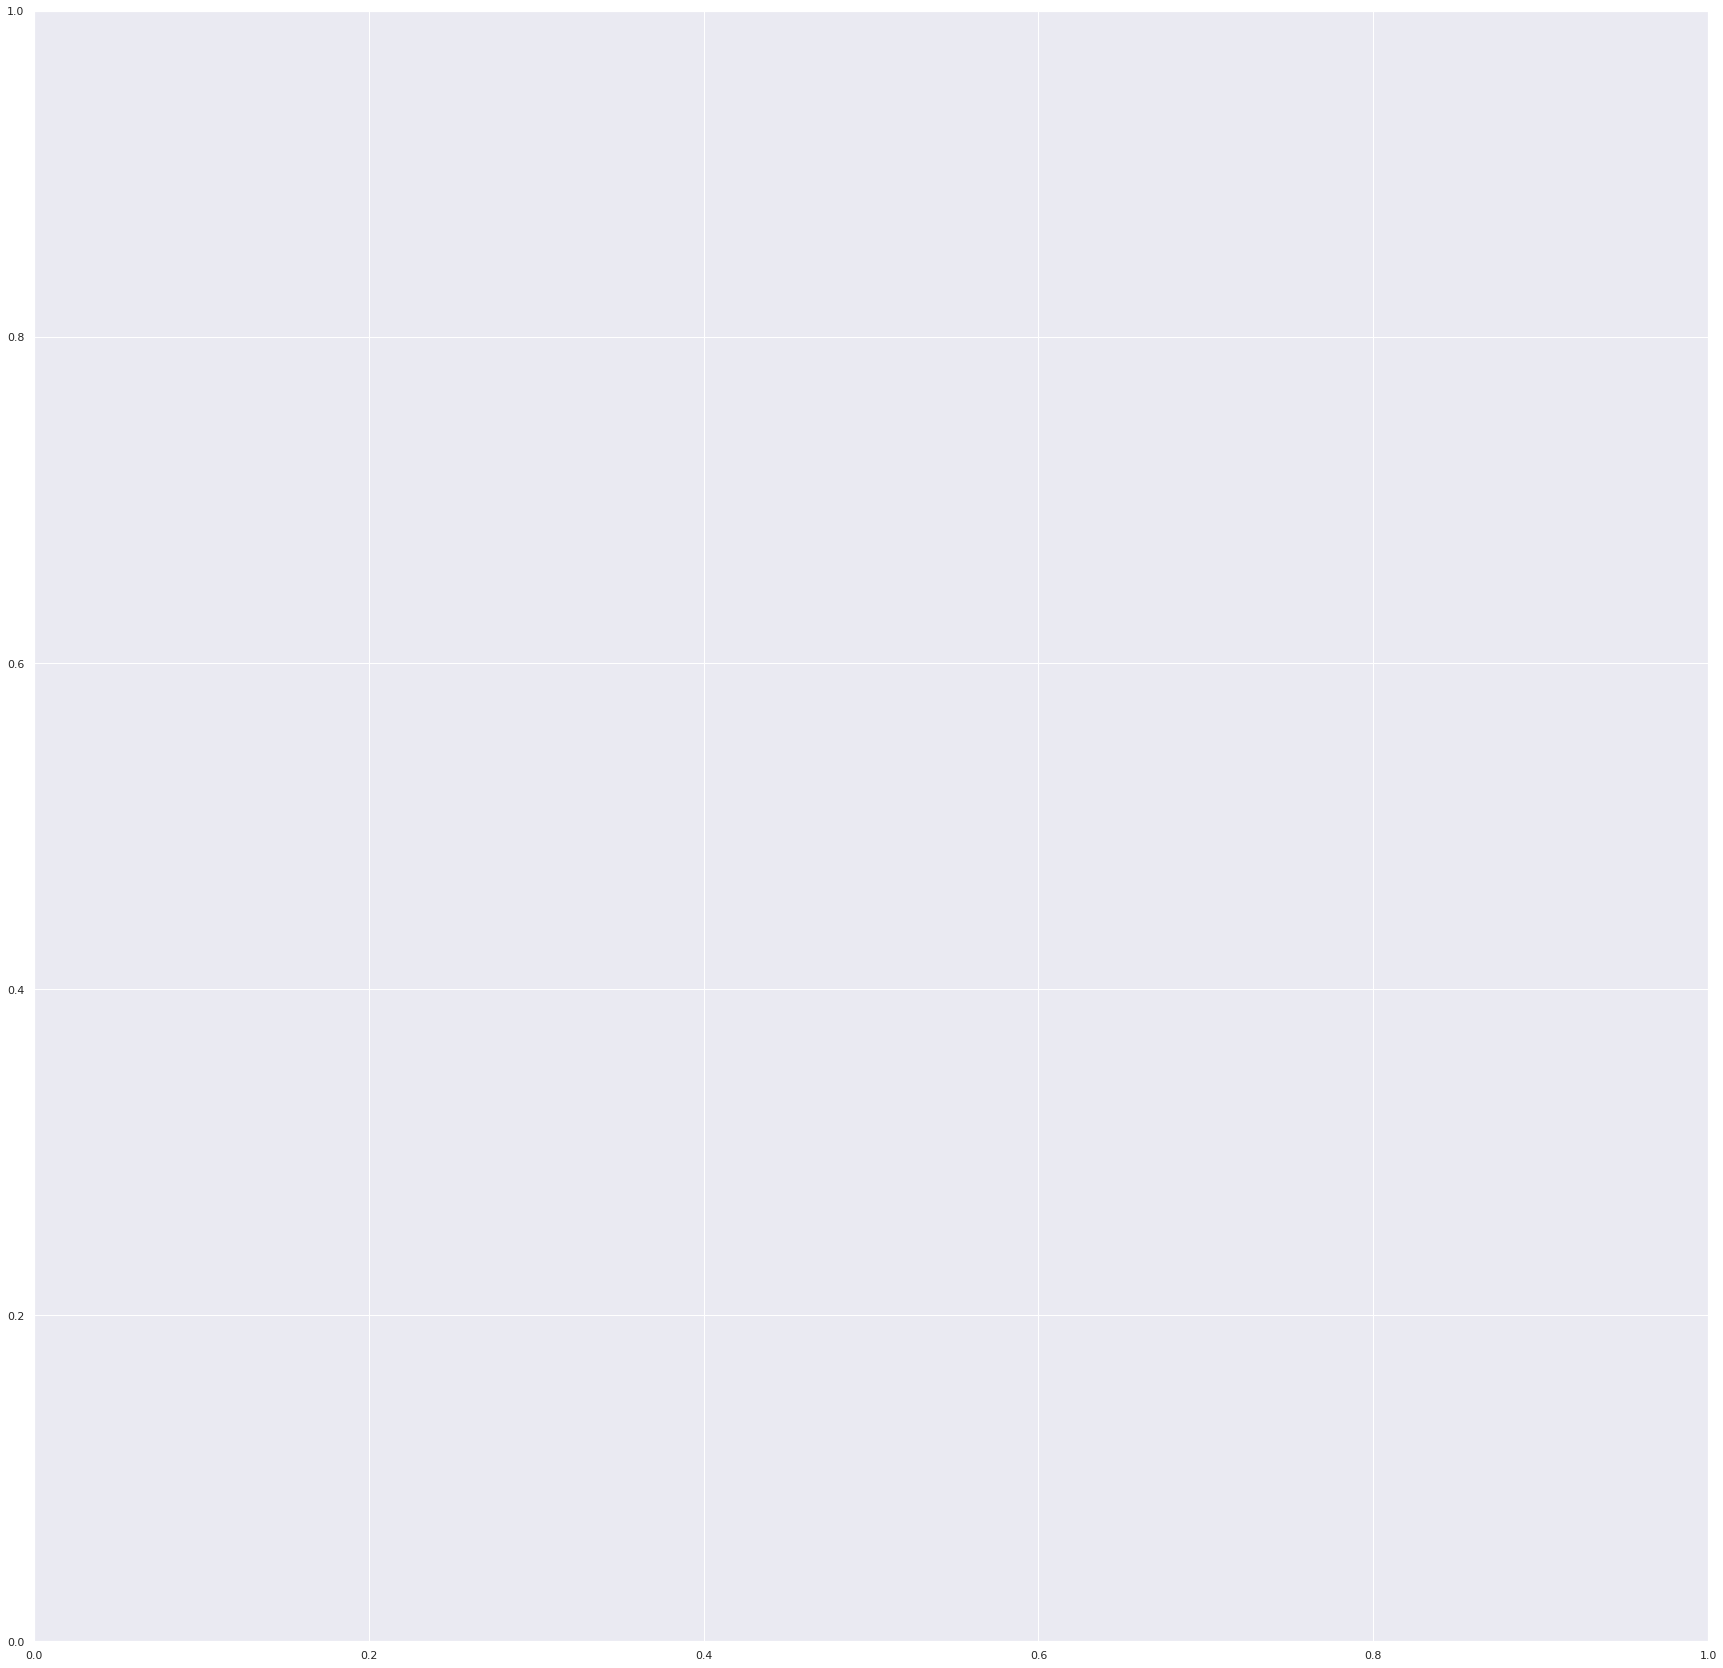

In [ ]:
# from sklearn.tree import plot_tree
# clf.fit(X_train,y_train)
# fig, ax = plt.subplots(figsize=(30,30))

# print(f"Profundidad del árbol: {clf.get_depth()}")
# print(f"Número de nodos terminales: {clf.get_n_leaves()}")

# plot = plot_tree(
#             decision_tree = clf,
#             feature_names = labels.tolist(),
#             class_names   = 'ventas_altas',
#             filled        = True,
#             impurity      = False,
#             fontsize      = 7,
#             ax            = ax
#        )

Accuracy =  0.5228655885932881


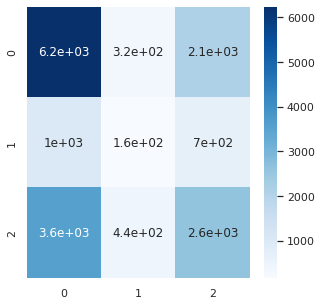

In [ ]:
sns.set(rc={"figure.figsize":(5,5)})
#Prediccion de los resultados de test en el random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)
clf.fit(X_train, y_train)
prediction_clf = clf.predict(X_test)

print ("Accuracy = ", accuracy_score(y_test, prediction_clf))
#Confusion Matrix - verify accuracy of each class

cm = confusion_matrix(y_test, prediction_clf)
sns.heatmap(cm, annot=True,cmap="Blues")
plt.show()


In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
auc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc_ovr', verbose=1)
acc = cross_val_score(clf, X, y, cv=10, scoring='accuracy', verbose=1)
print(auc.mean())
print(acc.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5961023727448335
0.5359858928125922


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.5s finished


In [ ]:
#Random forest grid search
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV

rf_clf = RandomForestClassifier(random_state=42)

n_estimators = [10,50,100,150,200]
max_features = ['auto', 'sqrt']
max_depth = [20, 25, 28, 30]
min_samples_split = [3,6,10,20]
min_samples_leaf = [2, 4, 6,10]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf_random = RandomizedSearchCV(estimator=rf_clf,
                               param_distributions = random_grid,
                               n_iter=15, cv = 10, verbose=2,
                               random_state=42, n_jobs=12, scoring='roc_auc_ovr')

rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15, n_jobs=12,
                   param_distributions={'max_depth': [20, 25, 28, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 10],
                                        'min_samples_split': [3, 6, 10, 20],
                                        'n_estimators': [10, 50, 100, 150,
                                                         200]},
                   random_state=42, scoring='roc_auc_ovr', verbose=2)

In [ ]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=6,
                       n_estimators=200, random_state=42)

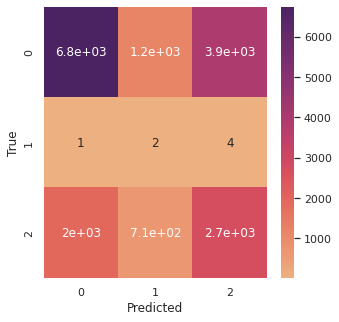

              precision    recall  f1-score   support

           0       0.78      0.57      0.66     11862
           1       0.00      0.29      0.00         7
           2       0.41      0.51      0.45      5384

    accuracy                           0.55     17253
   macro avg       0.40      0.45      0.37     17253
weighted avg       0.66      0.55      0.59     17253



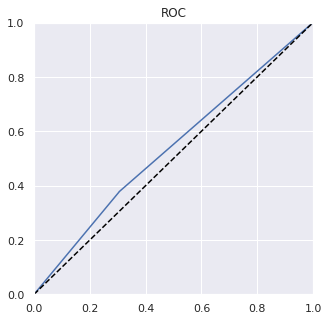

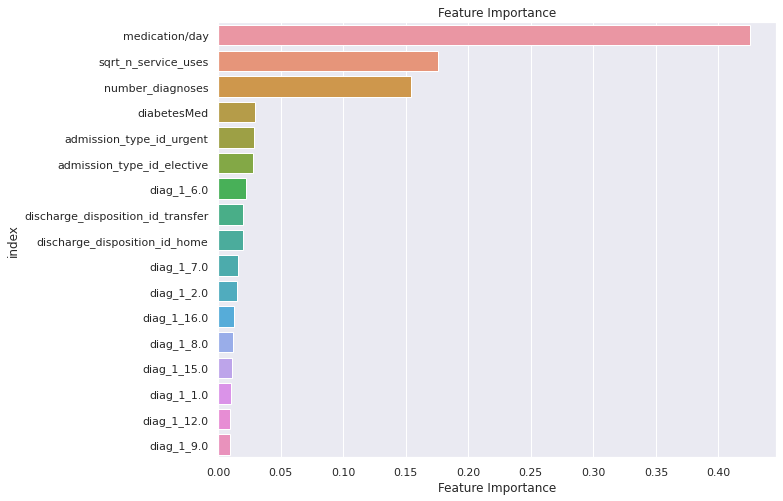

In [ ]:
clf = rf_random.best_estimator_
y_pred = clf.predict(X_test)
ax = sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, cmap="flare")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

print(classification_report(y_pred,y_test))

roc = roc_curve(y_test, y_pred, pos_label=1)
sns.lineplot(x=roc[0], y=roc[1])
sns.lineplot(x=[0,1], y=[0,1], linestyle='--', color='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC")
plt.show()

imp_df = pd.DataFrame(data=clf.feature_importances_, columns=['Feature Importance'],
                      index=categories)

imp_df.sort_values("Feature Importance", ascending=False, inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(y='index', x='Feature Importance', data=imp_df.reset_index())
plt.title("Feature Importance")
plt.show()

#PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                          'principal component 3','principal component 4',
                          'principal component 5'])

In [ ]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5
0,2.308806,-0.477371,1.582965,-2.078858,-0.169544
1,-1.248245,-0.604433,-1.396921,-0.301344,-3.075548
2,-0.486670,-0.859326,-0.580187,1.222058,1.224661
3,-0.360815,-0.855849,-0.287444,1.746670,1.304258
4,0.777197,-0.825910,1.525732,-1.732636,-1.442979
...,...,...,...,...,...
57504,-0.546761,-1.775127,-0.573256,-1.300729,1.806655
57505,-0.579744,-0.953719,2.150266,-0.628537,0.057421
57506,-0.393126,-0.426878,1.774297,1.157111,0.883126
57507,2.352497,0.307736,1.179391,-1.496598,-0.181639


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
auc = cross_val_score(rf, principalDf, y, cv=10, scoring='roc_auc_ovr', n_jobs=-1)
acc = cross_val_score(rf, principalDf, y, cv=10, scoring='accuracy', n_jobs=-1)
print('Mean accuracy: ', round(acc.mean(), 2))
print('Mean ROC area: ', round(auc.mean(), 2))


Mean accuracy:  0.54
Mean ROC area:  0.62


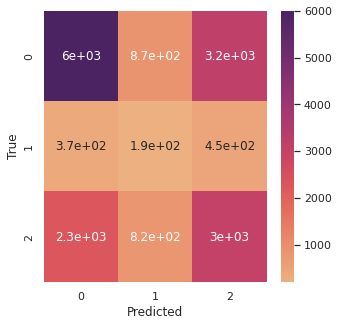

              precision    recall  f1-score   support

           0       0.69      0.60      0.64     10056
           1       0.10      0.19      0.13      1012
           2       0.46      0.49      0.47      6185

    accuracy                           0.54     17253
   macro avg       0.42      0.43      0.42     17253
weighted avg       0.57      0.54      0.55     17253



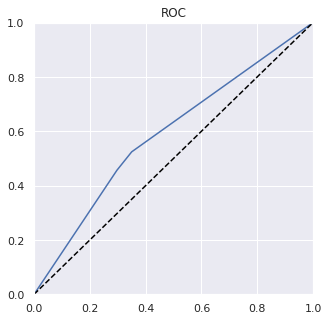

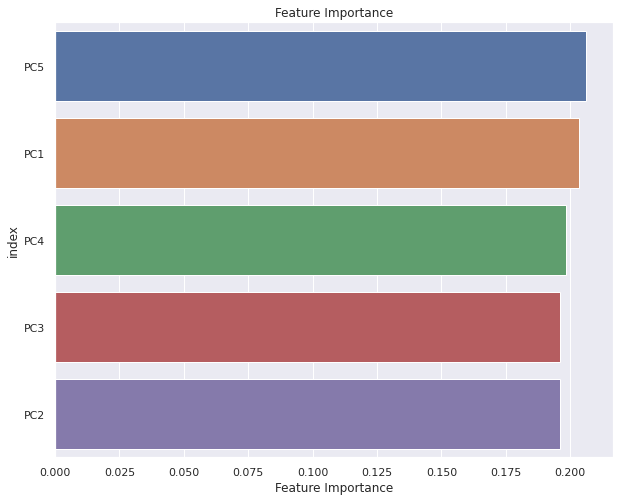

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
sns.set(rc={"figure.figsize":(5,5)})
#Prediccion de los resultados de test en el random forest
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y, test_size=0.3, stratify = y, random_state=42)

rf.fit(X_train, y_train)
prediction_clf = rf.predict(X_test)

ax = sns.heatmap(confusion_matrix(prediction_clf, y_test), annot=True, cmap="flare")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

print(classification_report(prediction_clf,y_test))

roc = roc_curve(y_test, prediction_clf, pos_label=2)
sns.lineplot(x=roc[0], y=roc[1])
sns.lineplot(x=[0,1], y=[0,1], linestyle='--', color='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("ROC")
plt.show()

imp_df = pd.DataFrame(data=rf.feature_importances_, columns=['Feature Importance'],
                      index=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

imp_df.sort_values("Feature Importance", ascending=False, inplace=True)

plt.figure(figsize=(10,8))
sns.barplot(y='index', x='Feature Importance', data=imp_df.reset_index())
plt.title("Feature Importance")
plt.show()

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 32.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=07684235cd6153ea493fb143dfd3c4b89381db37b8e8e7beac1c9149815676d8
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
y_test = np.array(y_test)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import random
explainer = LimeTabularExplainer(X_train, mode="classification",
                                              class_names=['NO', '<30', '>30'],
                                              feature_names=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
                                             )

idx = random.randint(1, len(X_test))

print("Prediction : ", rf.predict(X_test[idx].reshape(1, -1))[0])
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(X_test[idx], rf.predict_proba, top_labels=3)

explanation.show_in_notebook()

Prediction :  0
Actual :      2


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test=to_categorical(y_test)

In [ ]:
import tensorflow as tf
auc=tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)

In [ ]:
X_train.shape

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Conv1D



model = Sequential()
model.add(Dense(256, activation ='relu', input_dim = 17))
model.add(Dense(128, activation ='relu'))
model.add(Dropout(.5))
model.add(Dense(86, activation ='relu'))
model.add(Dropout(.5))
model.add(Dense(64, activation ='relu'))
model.add(Dropout(.25))
model.add(Dense(32, activation ='relu'))
model.add(Dropout(.1))
model.add(Dense(16, activation ='relu'))
model.add(Dense(3, activation ='softmax'))



model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy",tf.keras.metrics.AUC()])

model.fit(X_train,
          y_train,
          verbose = 1,
          epochs =100,
          batch_size = 512,
          validation_data = (X_test, y_test))

Epoch 1/100
119/119 [==============================] - 4s 23ms/step - loss: 1.0899 - accuracy: 0.3783 - auc: 0.5550 - val_loss: 1.0674 - val_accuracy: 0.4282 - val_auc: 0.6115
Epoch 2/100
119/119 [==============================] - 2s 19ms/step - loss: 1.0700 - accuracy: 0.4170 - auc: 0.6018 - val_loss: 1.0598 - val_accuracy: 0.4346 - val_auc: 0.6238
Epoch 3/100
119/119 [==============================] - 2s 21ms/step - loss: 1.0609 - accuracy: 0.4299 - auc: 0.6150 - val_loss: 1.0508 - val_accuracy: 0.4445 - val_auc: 0.6336
Epoch 4/100
119/119 [==============================] - 2s 19ms/step - loss: 1.0554 - accuracy: 0.4364 - auc: 0.6231 - val_loss: 1.0482 - val_accuracy: 0.4466 - val_auc: 0.6371
Epoch 5/100
119/119 [==============================] - 2s 16ms/step - loss: 1.0519 - accuracy: 0.4413 - auc: 0.6278 - val_loss: 1.0467 - val_accuracy: 0.4490 - val_auc: 0.6393
Epoch 6/100
119/119 [==============================] - 2s 16ms/step - loss: 1.0495 - accuracy: 0.4458 - auc: 0.6308 - va

In [ ]:
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
sns.heatmap(matrix, annot=True)